# Tow_matters PiCar

In [42]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow_addons.metrics import RSquare
from imgaug import augmenters as img_aug

import warnings
import random
import cv2
import pickle
import requests
import time

from pushover import Client

warnings.filterwarnings('ignore')

In [43]:
# Code to send notification to my phone

class PushoverCallback(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, interval):
        super(PushoverCallback, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            message = f"Epoch {epoch + 1}: val_loss={logs['val_loss']:.4f}"
            self.client.send_message(message, title=self.title, sound=self.sound)

class TimeoutMonitor(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, timeout=300):
        super(TimeoutMonitor, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.timeout = timeout
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        if self.start_time is not None and (time.time() - self.start_time) > self.timeout:
            message = f"Training has not moved to the next epoch after {self.timeout} seconds"
            self.client.send_message(message, title=self.title, sound=self.sound)
            self.start_time = time.time()

pushover_api_token = 'a3vns7mdqta4mbp42eeqb1ymo6ear5'
pushover_user_key = 'u5c3e3f58nrkui6dpuk5njcpfigxie'
client = Client(pushover_user_key, api_token=pushover_api_token)

In [44]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [45]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [46]:
df.shape

(13793, 3)

In [47]:
#df = df.drop('image_id', axis=1)
#df.head()

In [48]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [49]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [50]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']

image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\10171.png']

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data\1.png
freq,1


In [51]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all = df_all.drop('angle', axis=1)
df_all.tail()

,speed,images
13788,1.0,../datasets/PiCar/train/training_data\13794.png
13789,1.0,../datasets/PiCar/train/training_data\13795.png
13790,0.0,../datasets/PiCar/train/training_data\13796.png
13791,0.0,../datasets/PiCar/train/training_data\13797.png
13792,1.0,../datasets/PiCar/train/training_data\13798.png


In [52]:
df_all.shape

(13793, 2)

In [53]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data\11.png
Speed: 0.0


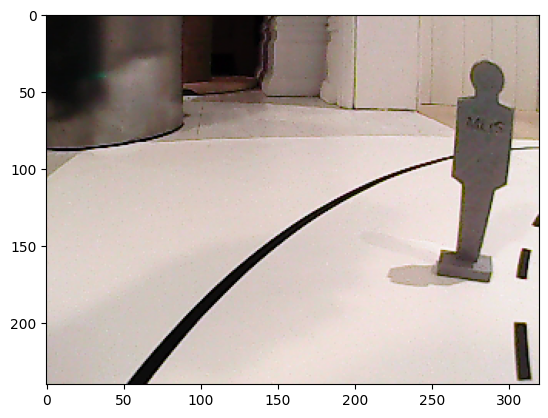

In [54]:
image_paths = df_all['images'].tolist()
speed = df_all['speed'].tolist()
image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("Speed:", speed[image_index]) 


(240, 320, 3)


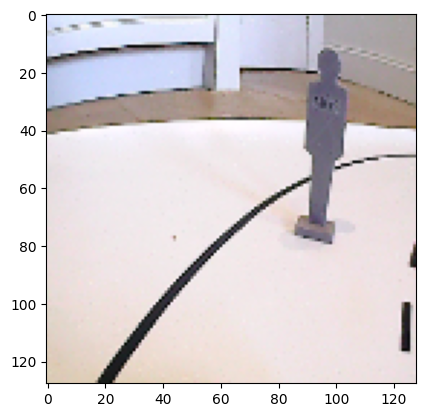

In [55]:
test_image = cv2.imread(df_all['images'][6])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
test_image = cv2.resize(test_image, (128,128))
plt.imshow(test_image)
plt.show()

In [56]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 11034
Validation data: 2759


In [57]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.2))  # zoom from 100% (no zoom) to 120%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 3)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    return image

In [58]:
def random_flip(image):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        image = cv2.flip(image,1)
    return image, is_flip

In [59]:
def custom_generator(df, batch_size, target_size, is_training):
    while True:
        # Shuffle the data
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df[i:i+batch_size]
            # Load images and labels
            images = []
            speeds = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                speed = row['speed']

                if is_training:
                    img = random_augment(img)
                    img, is_flip = random_flip(img)

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)

                images.append(img)
                speeds.append(speed)

            # Normalize images
            images = np.array(images) / 255.0
            speeds = np.array(speeds)
            yield images, speeds

In [60]:
from tensorflow.keras.applications import VGG16

class Nvidia_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    self.conv1 = Conv2D(64, 3, strides=(2, 2), activation='relu')

    self.flatten = Flatten()
    self.d1 = Dense(100, activation='relu')
    self.d2 = Dense(50, activation='relu')
    self.d3 = Dense(10, activation='relu')
    self.d4 = Dense(5, activation='relu')

    self.Y1 = Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.vgg(x)
    x = self.conv1(x)

    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)

    y1 = self.Y1(x)

    return y1

In [24]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
pushover_callback = PushoverCallback(client=client, title='Model Training Update', sound='cashregister', interval=3)
timeout_callback = TimeoutMonitor(client=client, title='Training Stuck!!!!!!!!', sound='falling')


train_gen = custom_generator(X_train, batch_size=32 ,target_size=(224, 224), is_training= True)
val_gen = custom_generator(X_valid, batch_size=32, target_size=(224, 224), is_training= False)

model = Nvidia_CNN()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics = 'accuracy')

history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 32,
                    validation_data=val_gen,
                    validation_steps=len(X_valid) // 32,
                    callbacks=[callback, pushover_callback, timeout_callback],
                    epochs=60)

model.save('model/Nvidia_CNN_speed',save_format='tf')

history_path = os.path.join('history_speed.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/60
344/344 [==============================] - 140s 365ms/step - loss: 0.1763 - accuracy: 0.9360 - val_loss: 0.0983 - val_accuracy: 0.9633
Epoch 2/60
344/344 [==============================] - 154s 407ms/step - loss: 0.0959 - accuracy: 0.9651 - val_loss: 0.0582 - val_accuracy: 0.9789
Epoch 3/60
344/344 [==============================] - 173s 504ms/step - loss: 0.0851 - accuracy: 0.9706 - val_loss: 0.0551 - val_accuracy: 0.9807
Epoch 4/60
344/344 [==============================] - 134s 391ms/step - loss: 0.0685 - accuracy: 0.9751 - val_loss: 0.0478 - val_accuracy: 0.9858
Epoch 5/60
344/344 [==============================] - 133s 387ms/step - loss: 0.0637 - accuracy: 0.9772 - val_loss: 0.0536 - val_accuracy: 0.9793
Epoch 6/60
344/344 [==============================] - 131s 380ms/step - loss: 0.0563 - accuracy: 0.9803 - val_loss: 0.0399 - val_accuracy: 0.9847
Epoch 7/60
344/344 [==============================] - 132s 383ms/step - loss: 0.0504 - accuracy: 0.9830 - val_loss: 0.0360 -

INFO:tensorflow:Assets written to: model/Nvidia_CNN_speed\assets


INFO:tensorflow:Assets written to: model/Nvidia_CNN_speed\assets


In [61]:
history_path = os.path.join('history_speed.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

def plots(history):
    # summarize history for accuracy
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,6))

    ax2.set_title('Speed Accuracy')
    ax2.plot(history['accuracy'])
    ax2.plot(history['val_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax4.set_title('Speed loss')
    ax4.plot(history['loss'])
    ax4.plot(history['val_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

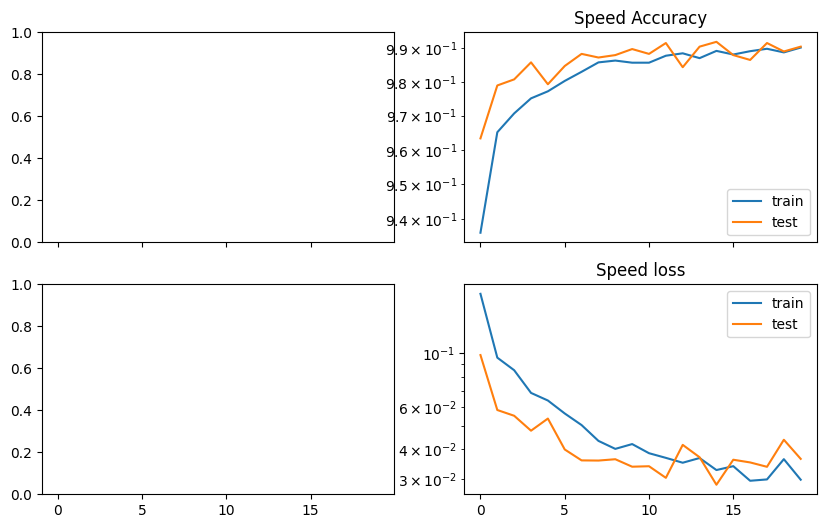

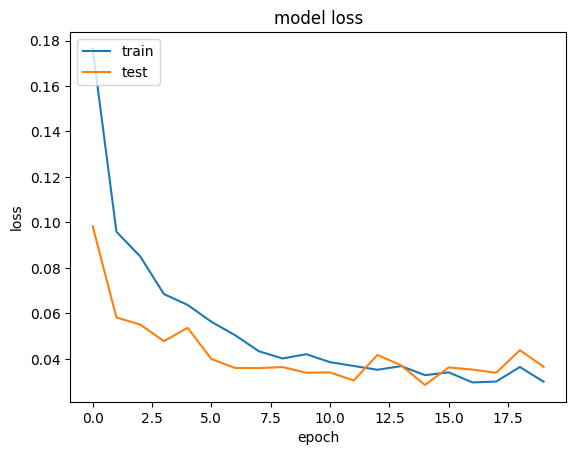

In [62]:
plots(history)

In [63]:
images_dir = '../datasets/PiCar/test'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,1020
unique,1020
top,../datasets/PiCar/test\1.png
freq,1


In [64]:
def test_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [65]:
from keras.models import load_model
model = load_model('model/Nvidia_CNN_speed')
testgen = next(test_generator(images, batch_size=1020, target_size=(224, 224)))
predict = model.predict(testgen)
print(predict)

32/32 [==============================] - 3s 75ms/step
[[1.3269458e-07]
 [9.9999988e-01]
 [9.9892384e-01]
 ...
 [9.9999988e-01]
 [9.9799037e-01]
 [9.9877816e-01]]


In [66]:
speed = pd.DataFrame(predict, columns=['speed'])
pred_df = pd.concat([speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,speed
0,1,1.326946e-07
1,2,9.999999e-01
2,3,9.989238e-01
3,4,9.993790e-01
4,5,9.997393e-01


In [67]:
pred_df = pred_df.round({'speed': 0})
pred_df.head()

,image_id,speed
0,1,0.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [68]:
pred_df.to_csv('Tow_mat4.csv', index=False)

In [35]:
test = next(custom_generator(X_valid, batch_size=10, target_size=(224, 224), is_training=False))

In [40]:
predict_test = model.predict(test[0])

1/1 [==============================] - 0s 18ms/step


In [41]:
print(predict_test)

[[9.9999964e-01]
 [9.9999785e-01]
 [9.9999940e-01]
 [1.0000000e+00]
 [3.8772687e-06]
 [9.9999881e-01]
 [9.9999976e-01]
 [9.9999988e-01]
 [9.9999976e-01]
 [1.7658112e-07]]


In [38]:
print(test[1])

[1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
